In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score,balanced_accuracy_score
import umap
import os


import import_ipynb
import model_correlation_epoch_evolution
from model_correlation_epoch_evolution import get_models_path, get_epochs, check_embeddings, loader, chose_target, scale_based_on_UKB, classifier

In [14]:
sns.set_theme(style="darkgrid")

In [15]:
# rootdir = '/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Output/2024-05-23/' #Strange one, likely due to branch merging issues 

# rootdir = '/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Output/2024-05-27/' # very consistent
# rootdir = '/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Output/2024-05-28/' # very consistent too
# rootdir = '/neurospin/dico/adufournet/Runs/04_Heritability_Right_PCS_HCP_dim10/Output/2024-05-29/' # to try !!!! Strange one too

# rootdir = '/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Output/2024-05-29/' # to try !!! very consistent
# rootdir = '/neurospin/dico/adufournet/Runs/05_Heritability_Left_PCS_HCP_dim10/Output/2024-05-23/' # what is expected

# rootdir = '/neurospin/dico/adufournet/mycode/Output/2024-07-22/'
rootdir = '/neurospin/dico/adufournet/mycode/Output//2024-07-23/'

#model_date = rootdir[75:85]
model_date = '2024-07-23'
side = 'LEFT'
region = 'CINGULATE'

In [16]:
def encoder(df, columns):
    for col in columns:
        code = {'present':1,
                'absent':0}
        df[col] = df[col].map(code)
    return df

labels_ACCP = pd.read_csv("/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/subjects_labels.csv")
labels_ACCP = labels_ACCP[['long_name','Left_PCS', 'Right_PCS']]

encoder(labels_ACCP, ['Left_PCS', 'Right_PCS']) 
labels_ACCP['Asymmetry'] = abs(labels_ACCP.Left_PCS - labels_ACCP.Right_PCS)

In [17]:
list_to_drop = ['Asymmetry','Left_PCS','Right_PCS']

list_model = get_models_path(rootdir)   
epochs = get_epochs(f'{rootdir}{list_model[0]}/')
target = 'Left_PCS'

list_of_people_to_follow = ['sub-4662034', 'sub-4168749', 'sub-2815300', 'sub-2302098','sub-5587423', 'sub-5627925', 'sub-4167965', 'sub-5040269', 'sub-4405541', 'sub-1816223', 'sub-4170820']
#Assign a unique color for each person to follow
colors = sns.color_palette(n_colors=len(list_of_people_to_follow))

0it [00:00, ?it/s]

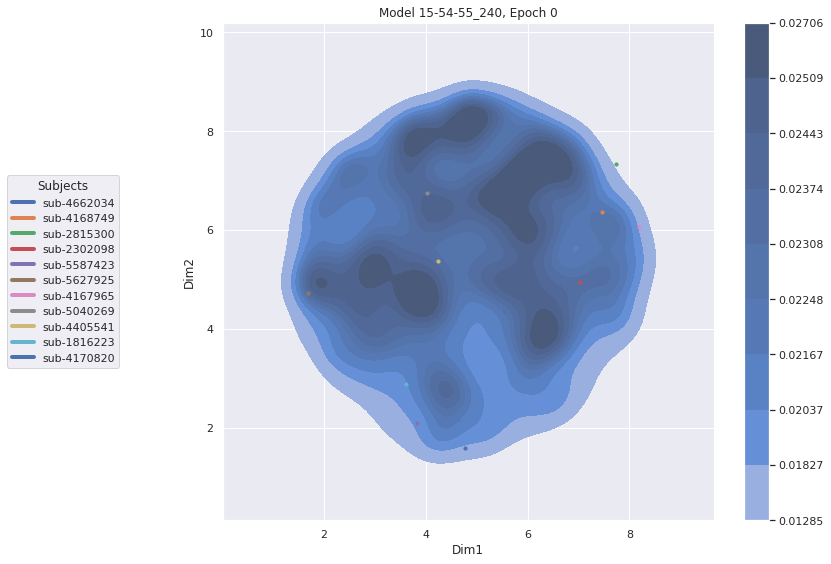

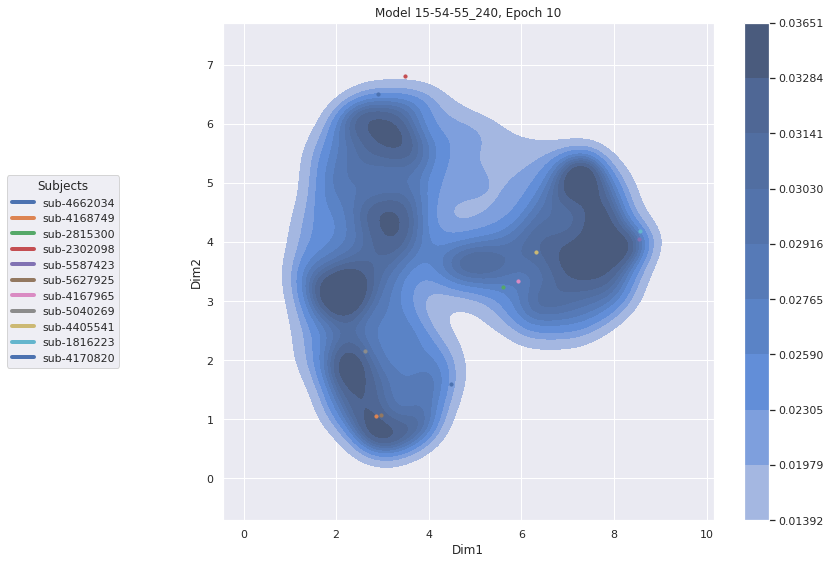

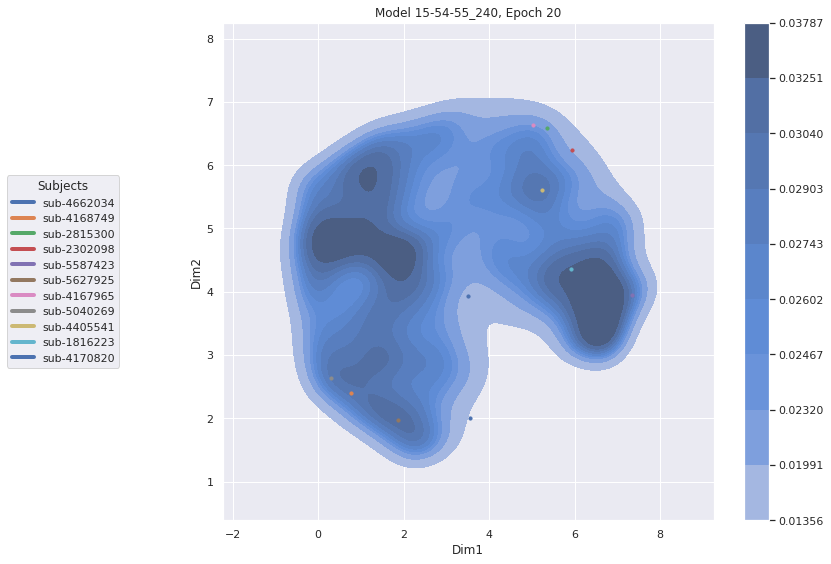

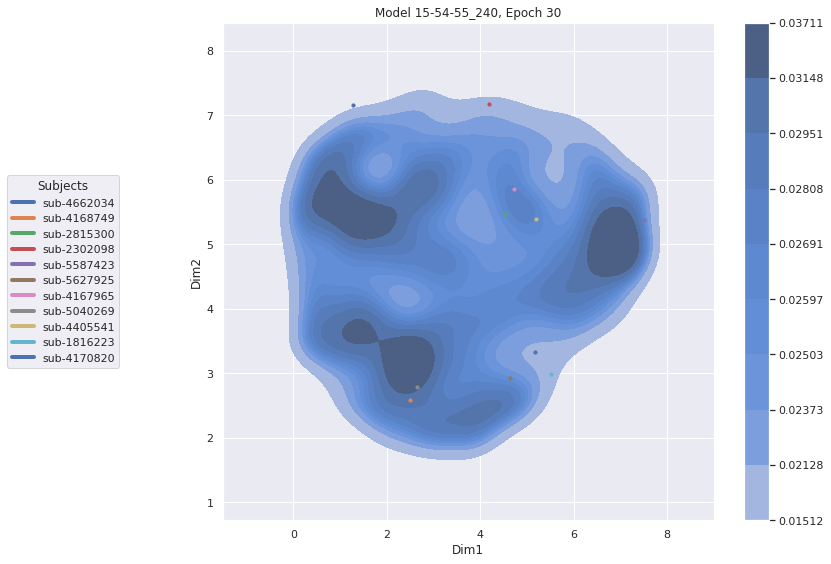

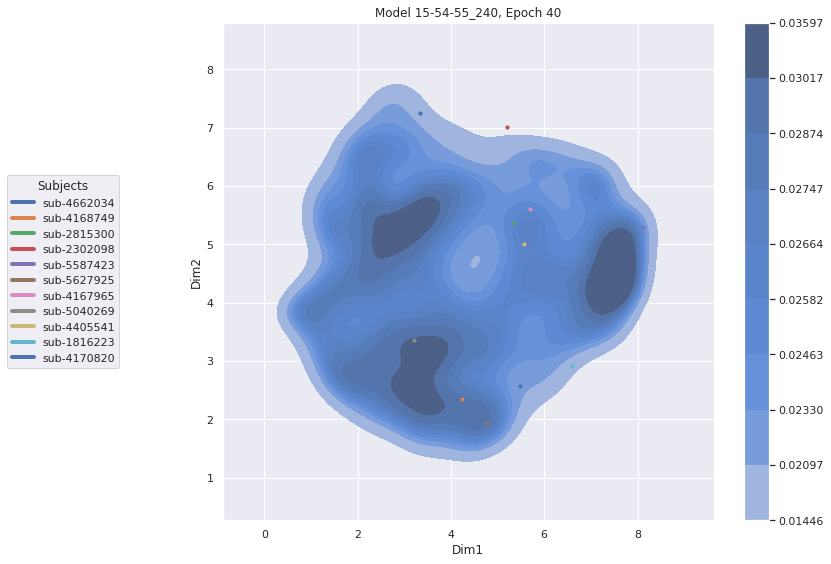

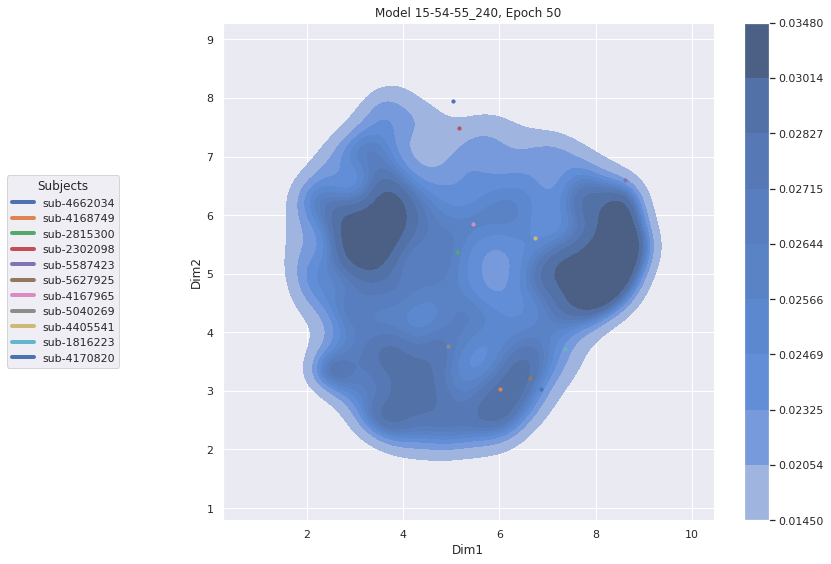

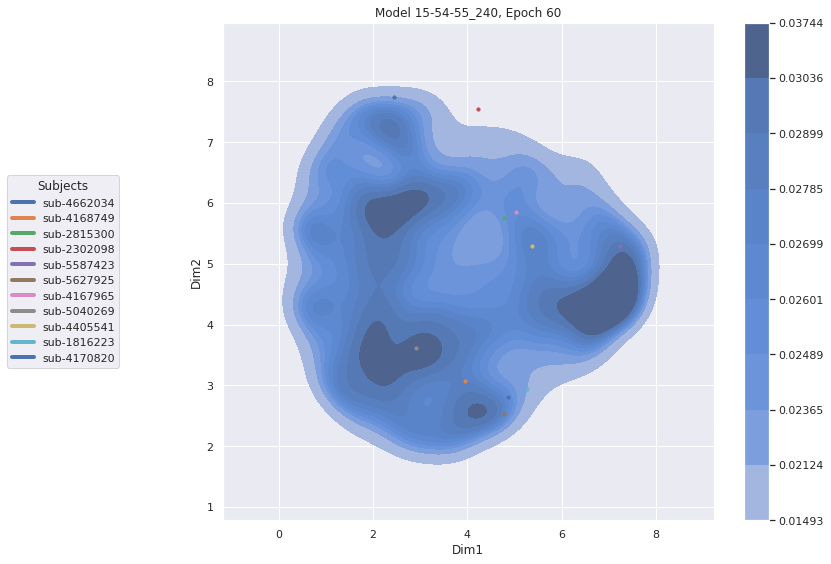

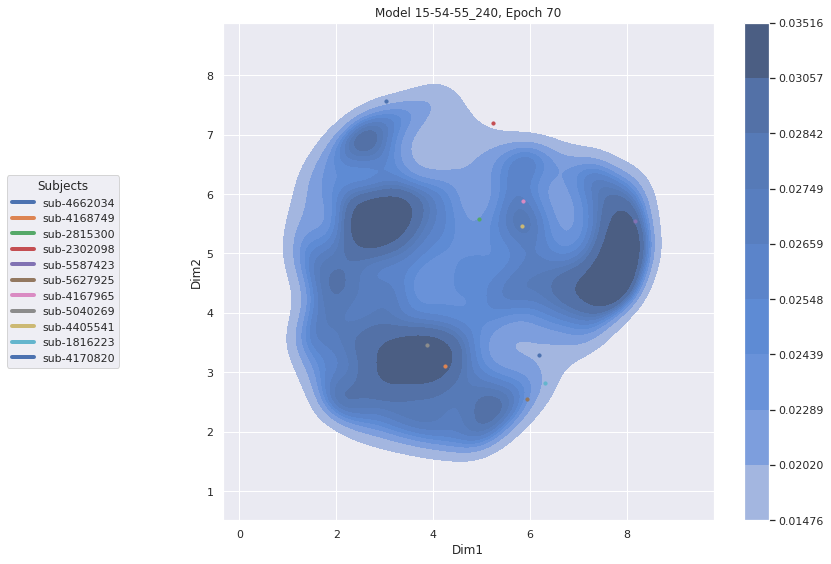

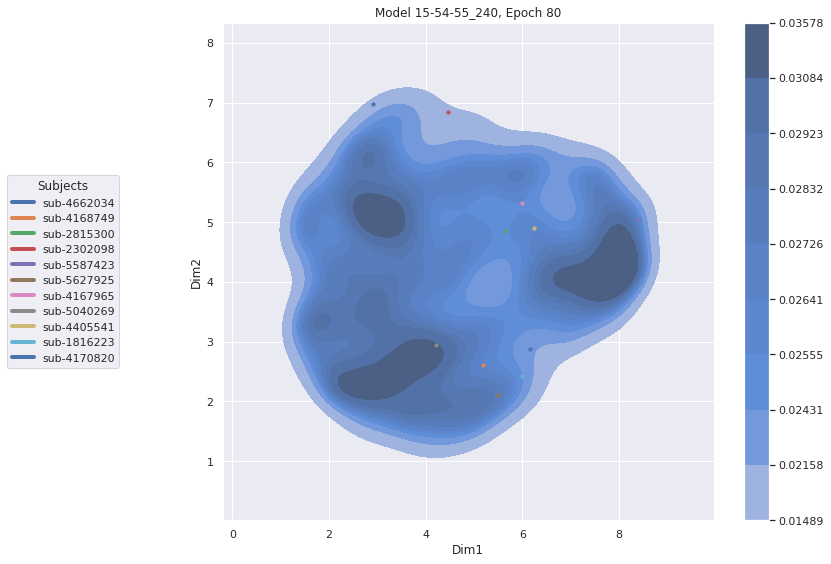

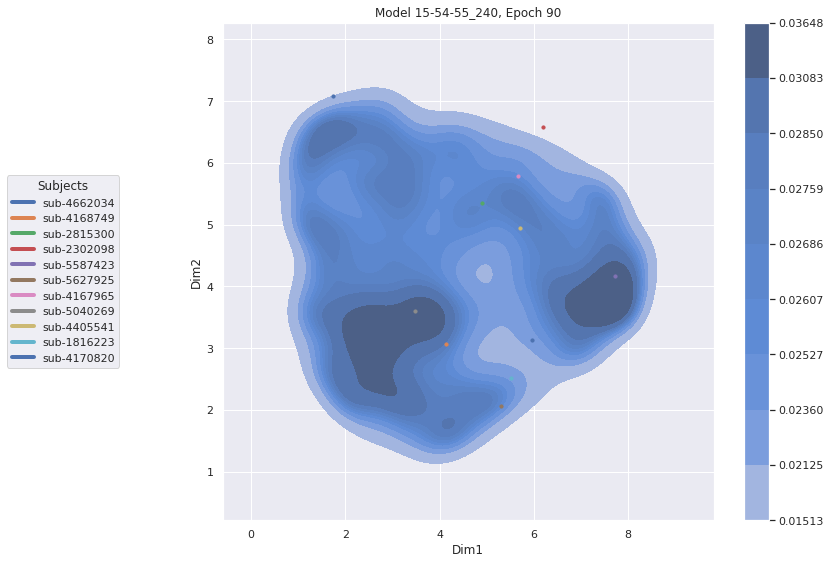

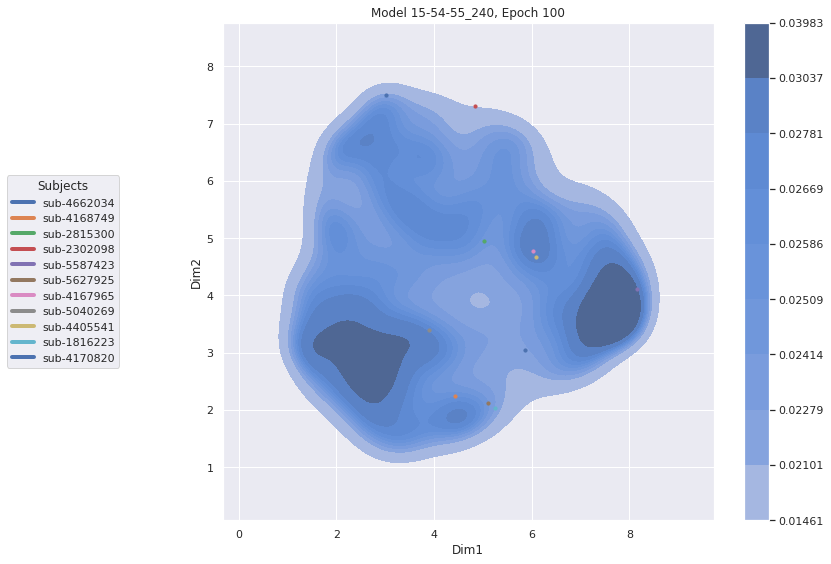

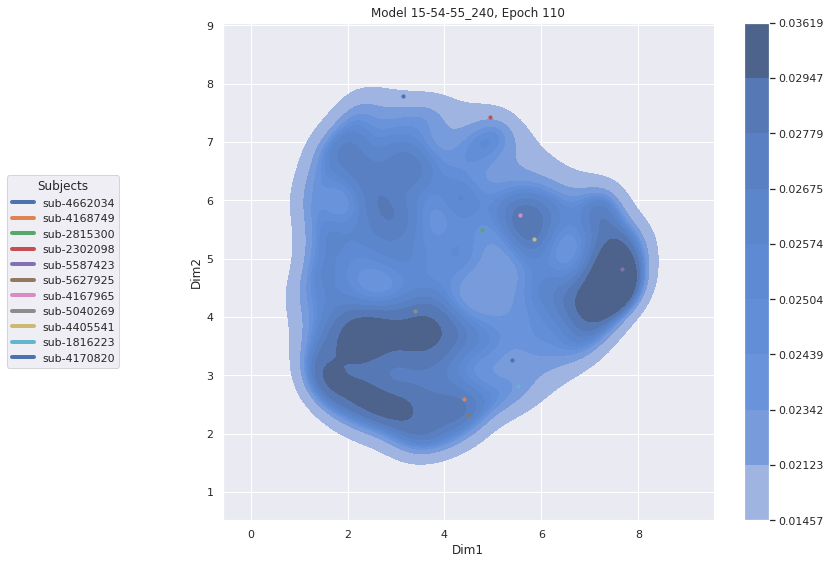

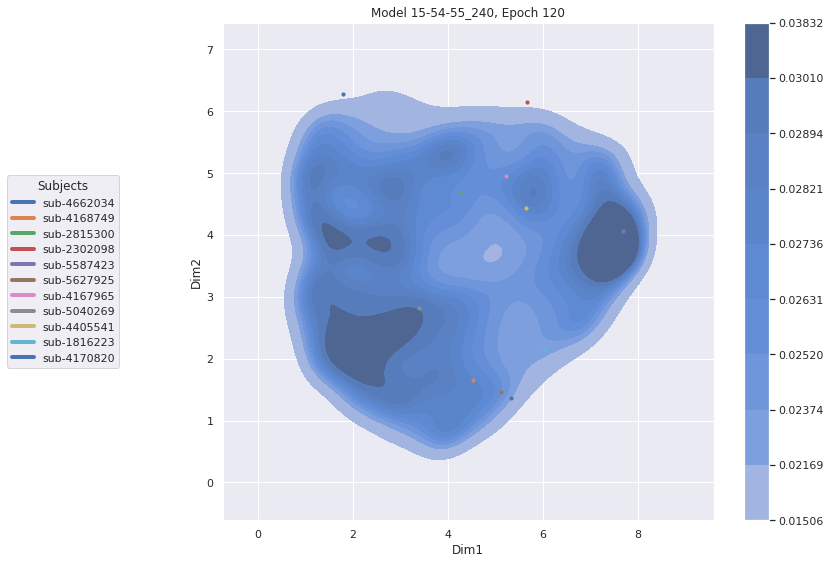

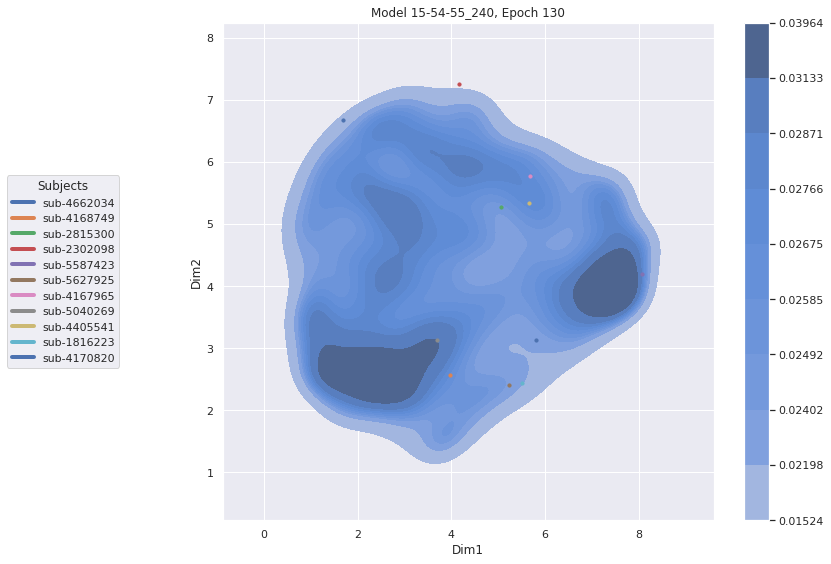

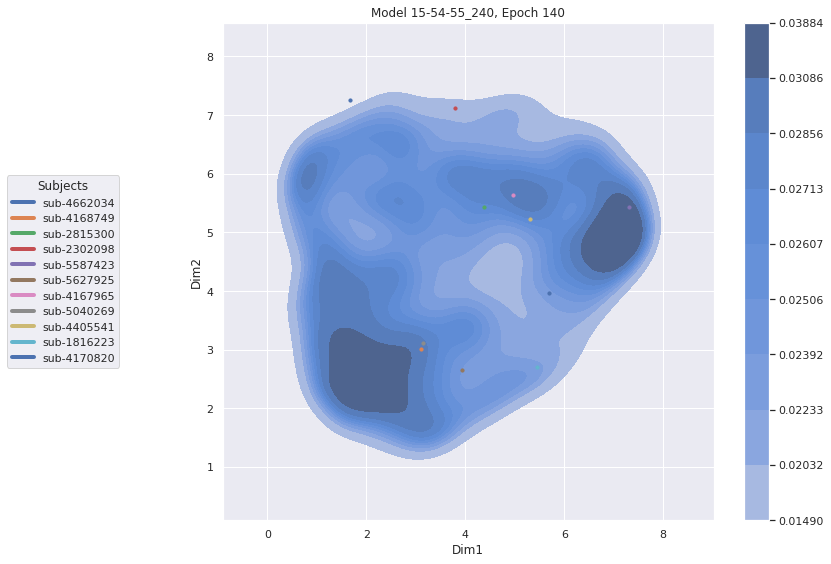

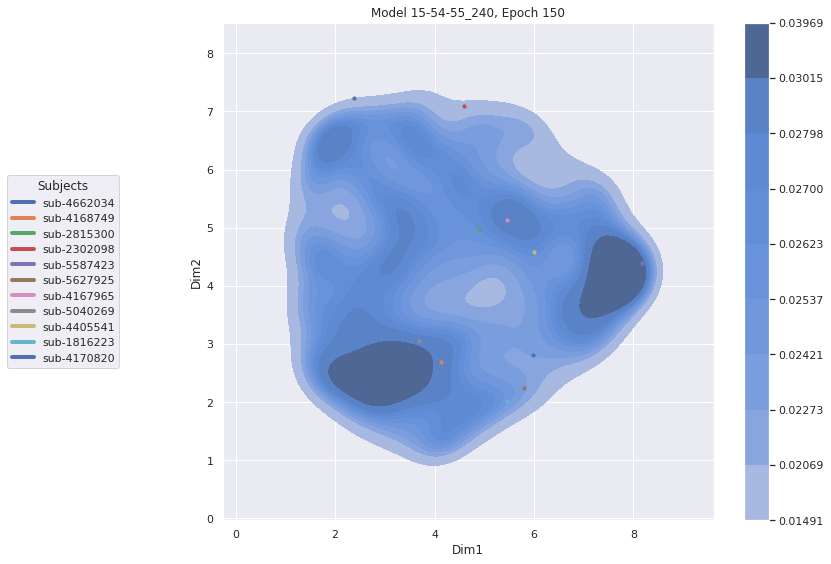

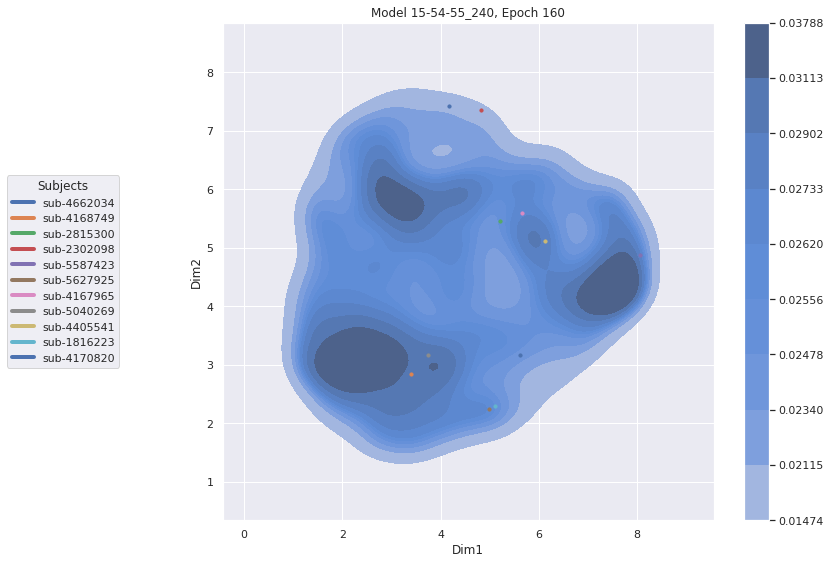

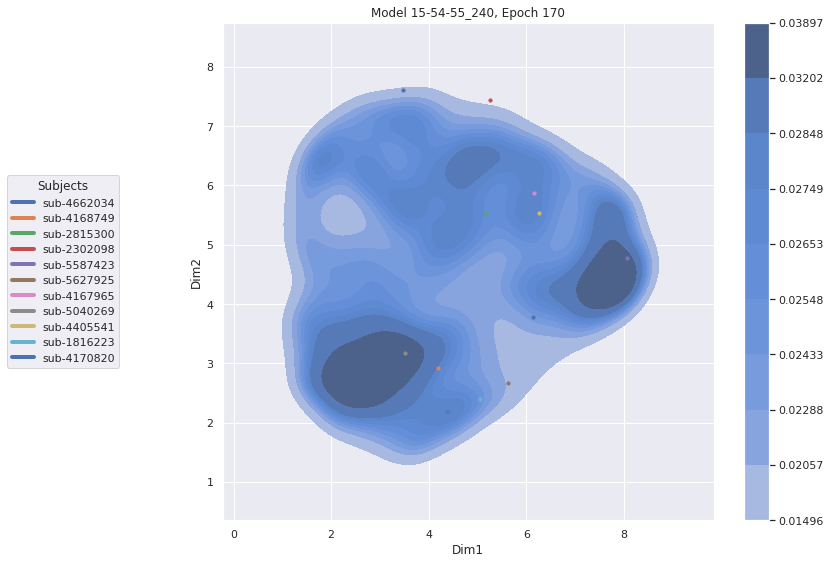

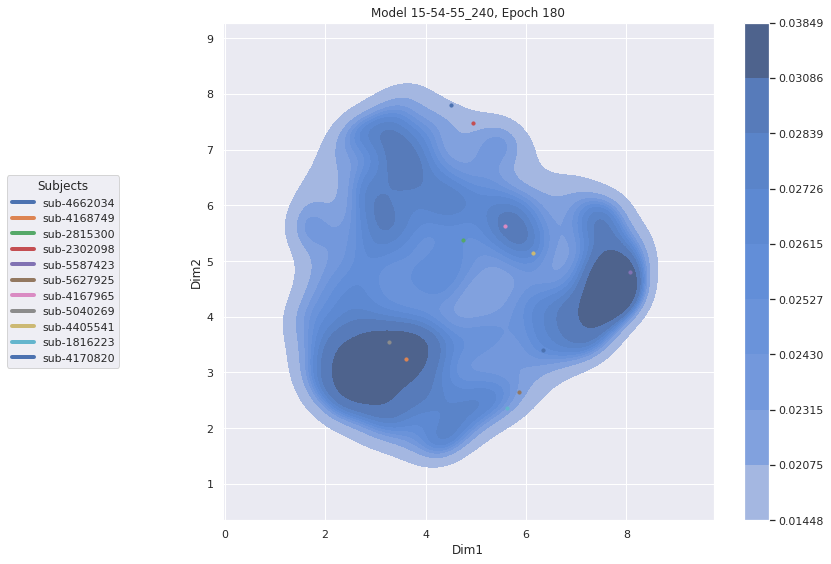

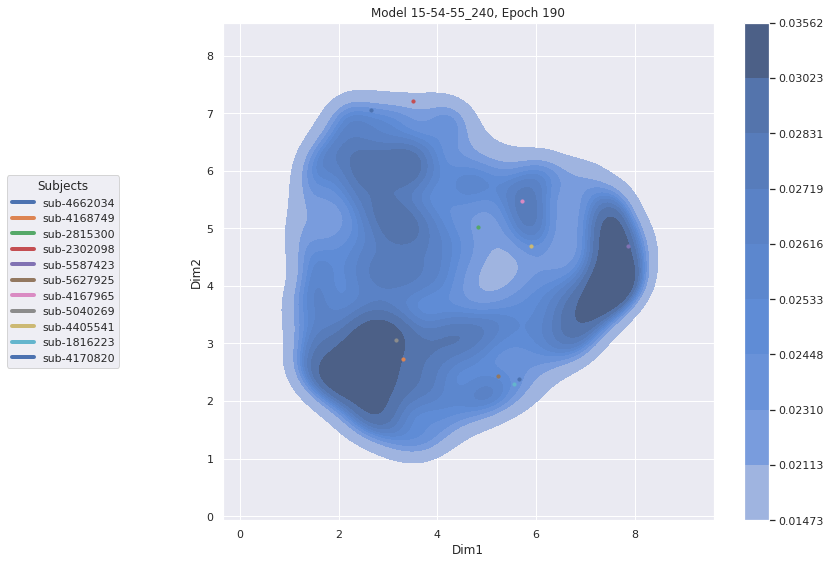

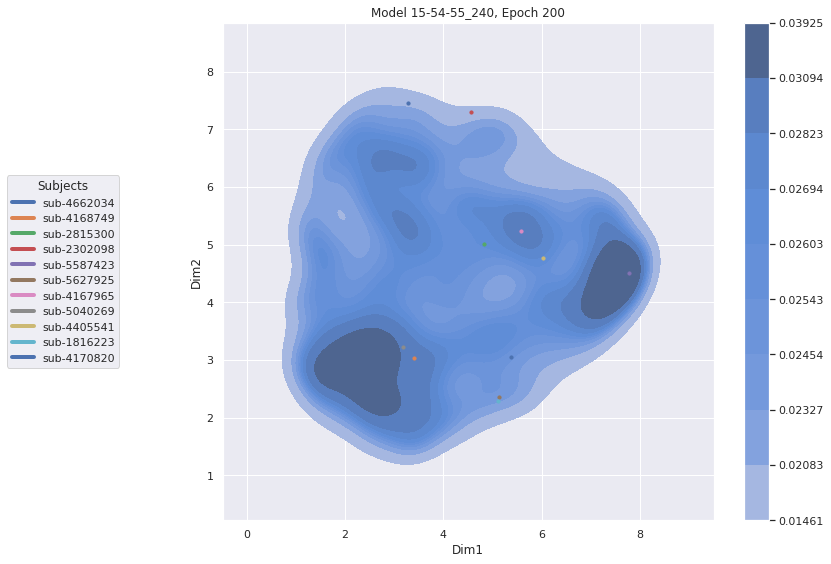

1it [21:09, 1269.97s/it]


In [19]:
UKBioBank_only = True
classification_evaluation = False
stratification_evaluation = False

strat_dic = {}
strat_path = '/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/'

for file in os.listdir(strat_path):
    if file.startswith('ACCpatterns_subjects_train_split'):
        strat_dic[f'train{file[-5:-4]}'] = pd.read_csv(f"{strat_path}{file}")
    if file.startswith('ACCpatterns_subjects_test_split'):
        strat_dic[f'test{file[-5:-4]}'] = pd.read_csv(f"{strat_path}{file}")

list_corr_mean = []
list_corr_std = []

eval_dic = {}

for i, str_model in tqdm(enumerate(list_model)):
    #fig, axs = plt.subplots(ncols=len(epochs), figsize=(16 * len(epochs), 16))
    pred_dic = {}
    for j, epoch in enumerate(np.sort(list(epochs))):
        path = f'{rootdir}{str_model}/'
        #path = str_model+'/'
        if not UKBioBank_only:
            embeddings_ACCP, embeddings_HCP, embeddings_UKB = loader(path, epoch)

            ebdd_lbl_ACCP, X, y = chose_target(target, embeddings_ACCP, labels_ACCP)
            scl_bdd_accp, scl_bdd_hcp, scl_bdd_ukb, scaler = scale_based_on_UKB(X, embeddings_HCP, embeddings_UKB)
            X = scl_bdd_accp
            model = classifier()

            if classification_evaluation:
                if stratification_evaluation:
                    X_train, X_test = np.array([[]]), np.array([[]])
                    y_train, y_test = [], []
                    for key in strat_dic.keys():
                        if key.startswith('train'):
                            new_train_lines = ebdd_lbl_ACCP.loc[strat_dic[key][strat_dic[key].columns[0]]].drop(list_to_drop, axis=1).to_numpy()
                            X_train = np.vstack((X_train, new_train_lines)) if X_train.size else new_train_lines
                            y_train += ebdd_lbl_ACCP.loc[strat_dic[key][strat_dic[key].columns[0]]][target].to_list()
                            
                        if key.startswith('test'):
                            new_test_lines = ebdd_lbl_ACCP.loc[strat_dic[key][strat_dic[key].columns[0]]].drop(list_to_drop, axis=1).to_numpy()
                            X_test = np.vstack((X_test, new_test_lines)) if X_test.size else new_test_lines
                            y_test += ebdd_lbl_ACCP.loc[strat_dic[key][strat_dic[key].columns[0]]][target].to_list()

                    X_train = scaler.transform(X_train)
                    X_test = scaler.transform(X_test)
                    model.fit(X_train, y_train)
                    eval_dic[f'auc_{target}_model{str_model[-1]}_epoch{epoch}'] = roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
                    eval_dic[f'balanced_accuracy_score_{target}_model{str_model[-1]}_epoch{epoch}'] = balanced_accuracy_score(y_test, model.predict(X_test))
                    X_train, X_test = np.array([[]]), np.array([[]])
                    y_train, y_test = [], []
                else:
                    val_pred = cross_val_predict(model, X, y, cv=5)
                    auc = roc_auc_score(y, val_pred)
                    eval_dic[f'auc_{target}_model{str_model[-1]}_epoch{epoch}'] = roc_auc_score(y, val_pred)
                    eval_dic[f'balanced_accuracy_score_{target}_model{str_model[-1]}_epoch{epoch}'] = balanced_accuracy_score(y, val_pred)
                    
        else:
            embeddings_ACCP, embeddings_HCP, embeddings_UKB = loader(path, epoch, ['UKB'])
            scaler = StandardScaler()
            scl_bdd_ukb = scaler.fit_transform(embeddings_UKB)

        reducer = umap.UMAP(n_neighbors=200)
        reducer.fit(scl_bdd_ukb)
            
        bdd_2D_UKB = reducer.transform(scl_bdd_ukb) 
        bdd_2D_UKB = pd.DataFrame(bdd_2D_UKB, columns=['Dim1', 'Dim2'])
        bdd_2D_UKB['Dataset'] = 'UkBioBank'
        bdd_2D_UKB = bdd_2D_UKB.set_index(embeddings_UKB.index)
            
        if not UKBioBank_only:
            bdd_2D_ACCP = reducer.transform(scl_bdd_accp) 
            bdd_2D_HCP = reducer.transform(scl_bdd_hcp)
            bdd_2D_ACCP = pd.DataFrame(bdd_2D_ACCP, columns=['Dim1', 'Dim2'])
            bdd_2D_HCP = pd.DataFrame(bdd_2D_HCP, columns=['Dim1', 'Dim2'])
            bdd_2D_HCP['Dataset'] = 'hcp'
            bdd_2D_ACCP['Dataset'] = 'accp'
            bdd_2D_ACCP = bdd_2D_ACCP.set_index(embeddings_ACCP.index)
            bdd_2D_HCP = bdd_2D_HCP.set_index(embeddings_HCP.index)

        plt.figure(figsize=(12,8))
        sns.kdeplot(
            data=bdd_2D_UKB,
            x="Dim1",
            y="Dim2",
            thresh=.1,
            fill=True, 
            cbar=True
        )
        for idx, people_i in enumerate(list_of_people_to_follow):
            plt.scatter(bdd_2D_UKB.loc[people_i]['Dim1'], bdd_2D_UKB.loc[people_i]['Dim2'], s=10, color=colors[idx], label=f'{people_i}')
        plt.title(f'Model {str_model}, Epoch {epoch}')
            
        custom_lines = [plt.Line2D([0], [0], color=colors[idx], lw=4) for idx in range(len(list_of_people_to_follow))]
        plt.legend(custom_lines, [f'{people_i}' for people_i in list_of_people_to_follow], bbox_to_anchor=(-0.2, 0.5), loc='center right', title="Subjects")
        # Create the directory if it doesn't exist
        save_dir = f'/volatile/ad279118/2023_jlaval_STSbabies/contrastive/notebooks/antoine/{side}_{region}/UMAP_evolution/{model_date}/{str_model}/'
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        # Save the figure
        plt.tight_layout()
        plt.savefig(f'{save_dir}/epoch_{epoch}.png')
        plt.show()


In [32]:
eval_dic

{'auc_Right_PCS_model1_epoch0': 0.4829493087557603,
 'balanced_accuracy_score_Right_PCS_model1_epoch0': 0.4382488479262673,
 'auc_Right_PCS_model3_epoch0': 0.487557603686636,
 'balanced_accuracy_score_Right_PCS_model3_epoch0': 0.49539170506912444,
 'auc_Right_PCS_model0_epoch0': 0.5428571428571428,
 'balanced_accuracy_score_Right_PCS_model0_epoch0': 0.5778801843317972,
 'auc_Right_PCS_model4_epoch0': 0.7184331797235022,
 'balanced_accuracy_score_Right_PCS_model4_epoch0': 0.6456221198156682,
 'auc_Right_PCS_model2_epoch0': 0.5502304147465438,
 'balanced_accuracy_score_Right_PCS_model2_epoch0': 0.5474654377880184,
 'auc_Right_PCS_model1_epoch10': 0.8138248847926268,
 'balanced_accuracy_score_Right_PCS_model1_epoch10': 0.7101382488479262,
 'auc_Right_PCS_model3_epoch10': 0.7741935483870966,
 'balanced_accuracy_score_Right_PCS_model3_epoch10': 0.7511520737327189,
 'auc_Right_PCS_model0_epoch10': 0.8211981566820277,
 'balanced_accuracy_score_Right_PCS_model0_epoch10': 0.7244239631336405,
 '